<a href="https://colab.research.google.com/github/PatandyaW/ds-takehome/blob/main/notebooks/B_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from google.colab import drive
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Mount Google Drive
drive.mount('/content/drive')

# Load the dataset
df = pd.read_csv('/content/drive/My Drive/DStest/credit_scoring.csv')

# Display the first 5 rows to inspect the data
df.sample(5)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default,leak_col_good,leak_col_subtle
2496,503496,34,10247687,9746828,1,449,0,0,0.055
3123,504123,45,17987223,2182017,0,680,0,0,-0.022
3299,504299,42,14464050,10537112,0,635,0,0,0.059
5133,506133,49,7253588,1175296,1,731,0,0,-0.026
1813,502813,32,5365188,4627932,0,632,0,0,0.022


In [7]:
missing_values = df.isnull().sum()
print("Missing Values:\n", missing_values)

Missing Values:
 application_id       0
age                  0
monthly_income       0
loan_amount          0
previous_defaults    0
credit_score         0
default              0
leak_col_good        0
leak_col_subtle      0
dtype: int64


In [8]:
basic_stats = df.describe()
print("\nBasic Statistics:\n", basic_stats)


Basic Statistics:
        application_id          age  monthly_income   loan_amount  \
count     6000.000000  6000.000000    6.000000e+03  6.000000e+03   
mean    503999.500000    40.321500    1.140386e+07  8.001122e+06   
std       1732.195139    11.300697    4.912598e+06  4.071786e+06   
min     501000.000000    21.000000    3.000310e+06  1.000794e+06   
25%     502499.750000    31.000000    7.163379e+06  4.440939e+06   
50%     503999.500000    41.000000    1.129945e+07  7.982304e+06   
75%     505499.250000    50.000000    1.573705e+07  1.153144e+07   
max     506999.000000    59.000000    1.998622e+07  1.499858e+07   

       previous_defaults  credit_score      default  leak_col_good  \
count        6000.000000   6000.000000  6000.000000    6000.000000   
mean            0.243667    575.979833     0.012167       0.012167   
std             0.484767    158.328931     0.109639       0.109639   
min             0.000000    300.000000     0.000000       0.000000   
25%             0

In [9]:
df_cleaned = df.drop(columns=['leak_col_good', 'leak_col_subtle'])

df_cleaned.sample(5)

,application_id,age,monthly_income,loan_amount,previous_defaults,credit_score,default
4395,505395,40,14670092,13185364,0,589,0
134,501134,22,16566448,4204961,1,674,0
5052,506052,43,14202330,6423740,0,758,0
5834,506834,21,12108938,11690893,0,488,0
2711,503711,24,18927715,2958938,1,678,0


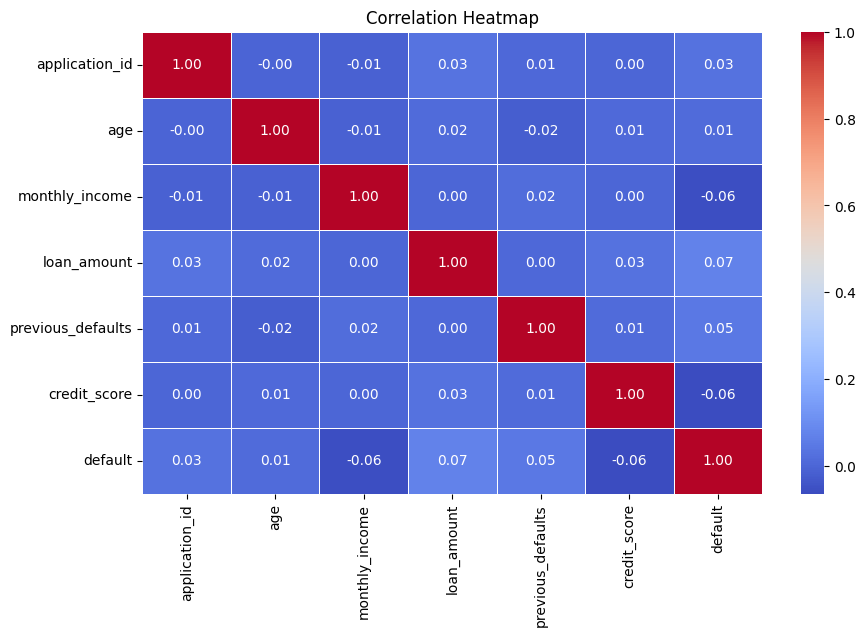

In [10]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_cleaned.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

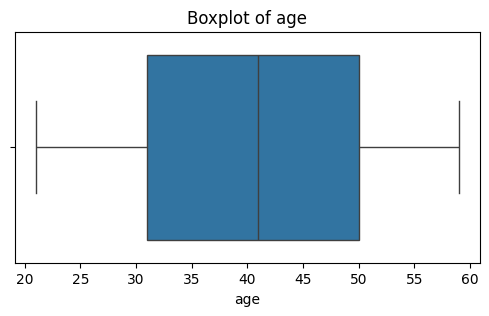

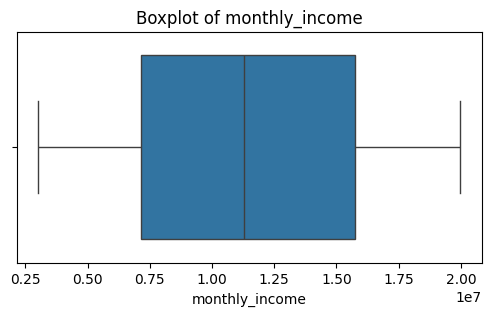

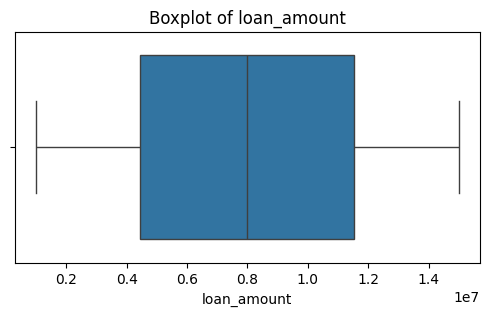

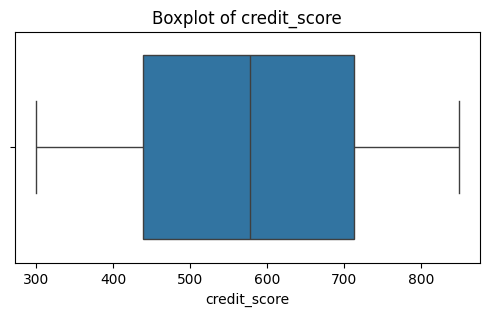

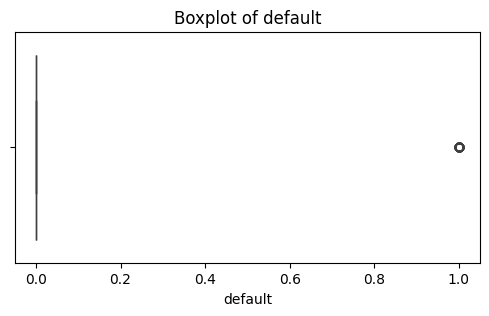

In [13]:
num_cols = ['age', 'monthly_income', 'loan_amount', 'credit_score', 'default']
for col in num_cols:
    plt.figure(figsize=(6, 3))
    sns.boxplot(x=df_cleaned[col])
    plt.title(f'Boxplot of {col}')
    plt.show()


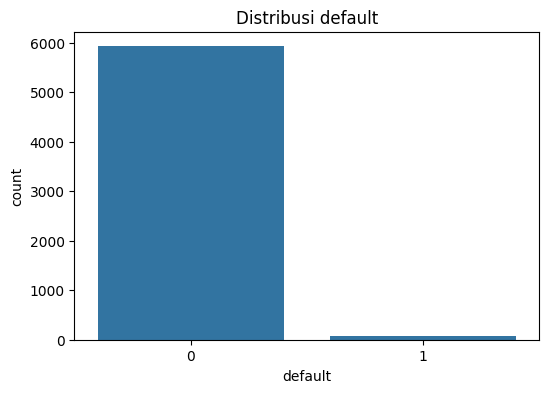

In [14]:
plt.figure(figsize=(6, 4))
sns.countplot(x='default', data=df_cleaned)
plt.title('Distribusi default')
plt.show()

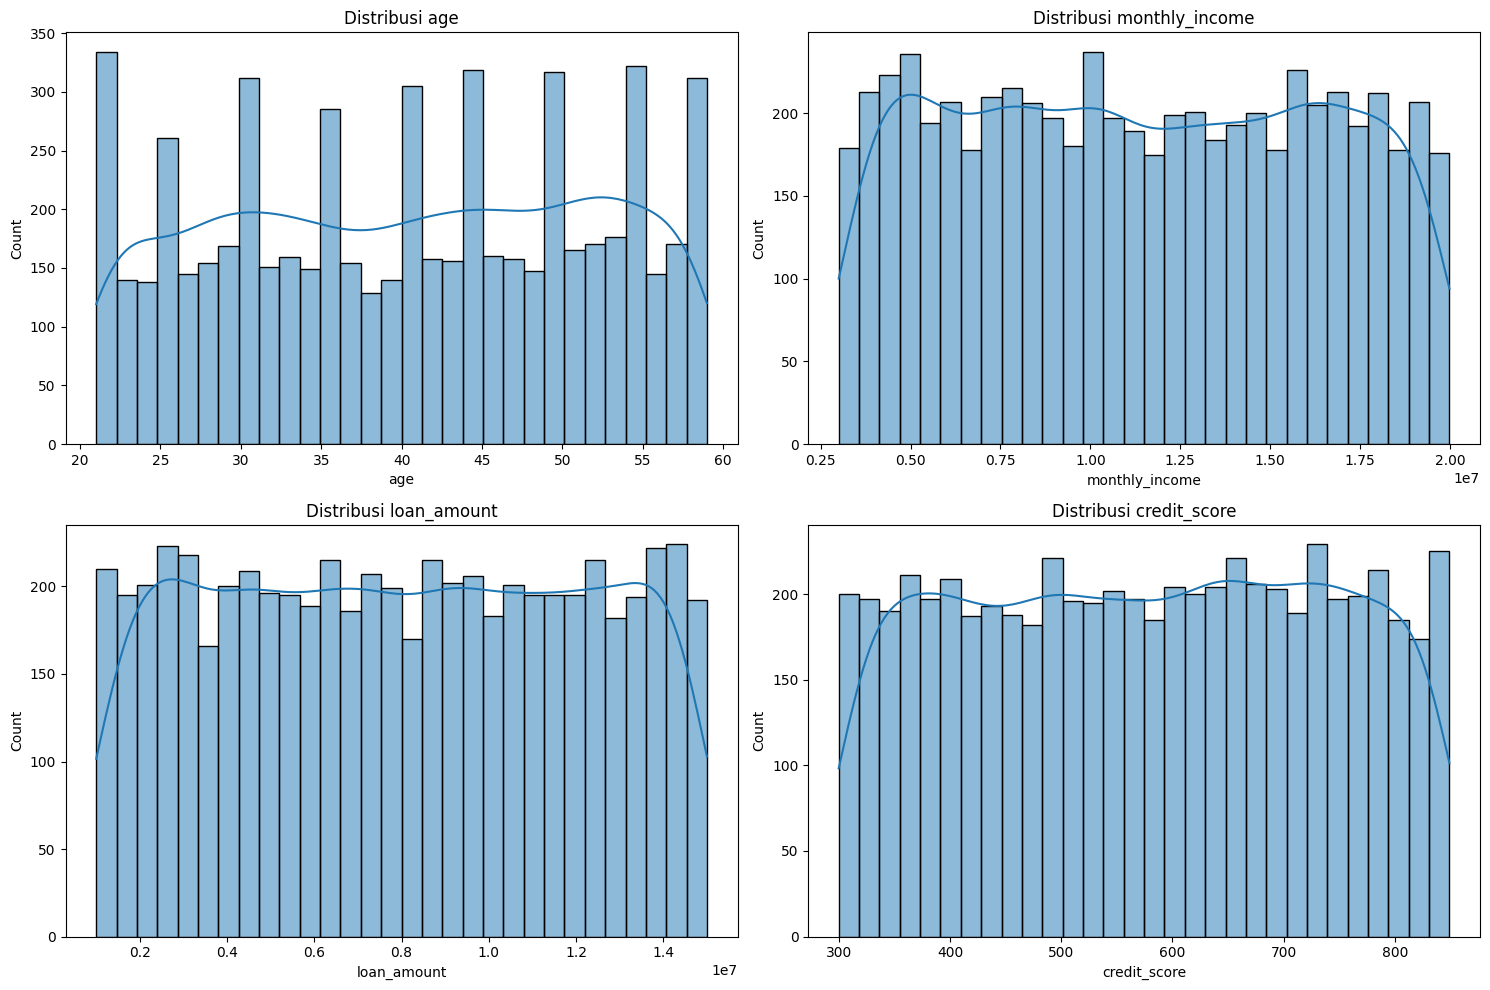

In [16]:
numerical_features = ['age', 'monthly_income', 'loan_amount', 'credit_score']

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df_cleaned[col], kde=True, bins=30)
    plt.title(f'Distribusi {col}')
    plt.xlabel(col)
plt.tight_layout()
plt.show()

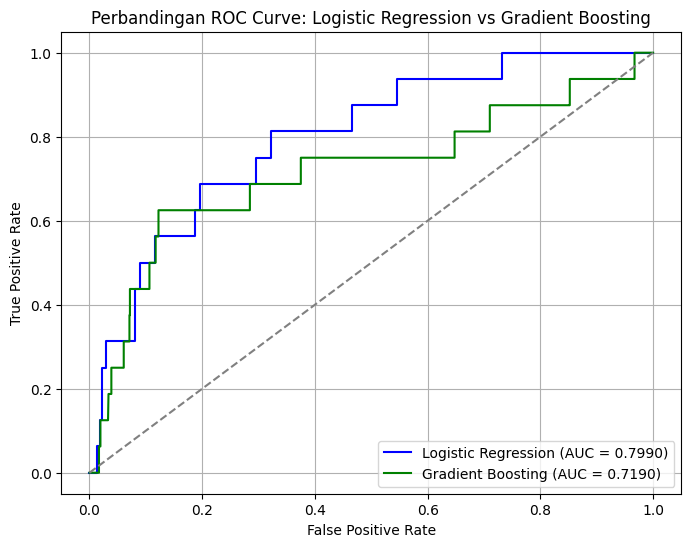

AUC Logistic Regression: 0.7990
AUC Gradient Boosting: 0.7190


In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


X = df_cleaned.drop(columns=['default', 'application_id'])
y = df_cleaned['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)


logreg_preds = logreg.predict_proba(X_test)[:, 1]
logreg_auc = roc_auc_score(y_test, logreg_preds)


ros = RandomOverSampler(sampling_strategy="not majority", random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)


gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train_resampled, y_train_resampled)


gb_preds = gb.predict_proba(X_test)[:, 1]
gb_auc = roc_auc_score(y_test, gb_preds)


fpr_logreg, tpr_logreg, _ = roc_curve(y_test, logreg_preds)
fpr_gb, tpr_gb, _ = roc_curve(y_test, gb_preds)


plt.figure(figsize=(8, 6))
plt.plot(fpr_logreg, tpr_logreg, color='blue', label=f'Logistic Regression (AUC = {logreg_auc:.4f})')
plt.plot(fpr_gb, tpr_gb, color='green', label=f'Gradient Boosting (AUC = {gb_auc:.4f})')


plt.plot([0, 1], [0, 1], color='gray', linestyle='--')


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Perbandingan ROC Curve: Logistic Regression vs Gradient Boosting')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


print(f"AUC Logistic Regression: {logreg_auc:.4f}")
print(f"AUC Gradient Boosting: {gb_auc:.4f}")
